In [45]:
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

IMG_SIZE = 220

2  CPU cores


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
os.chdir('/content/drive/MyDrive/Dataset')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Dataset


In [48]:
import pandas as pd
colnames = ["id_code", "diagnosis", "file_path", "file_name"]
def load_data():
    df_train_train = pd.read_csv('/content/drive/MyDrive/Dataset/train_acc2.csv', dtype=str, names=colnames, header=None)
    df_train_test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv', header=None)
    return df_train_train,df_train_test

In [49]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(3662, 4) (1929, 1) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/Dataset/train_images/00...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/Dataset/train_images/00...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/Dataset/train_images/00...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/Dataset/train_images/00...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/Dataset/train_images/00...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/Dataset/train_images/00...,0083ee8054ee.png


In [50]:
#train test split---------------
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train_train, test_size=0.15)

Preprocessing step

In [51]:
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [52]:
IMG_SIZE = 220

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
      
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

    
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 10) ,-4 ,128)
    return img 

def blur(image):
  #print(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = crop_image_from_gray(image)
  #print(image)
  image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

  return image

def preprocess_image(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_LANCZOS4)
    image = circle_crop(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_LANCZOS4)
    return image
  

In [53]:
# Model parameters
#####################
BATCH_SIZE = 32
EPOCHS = 15
WARMUP_EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = IMG_SIZE
WIDTH = IMG_SIZE
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 15
#ES_PATIENCE = 5
RLROP_PATIENCE = 15
#RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [54]:
'''rotation_range=360,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     preprocessing_function = preprocess_image,
                                     fill_mode='constant','''

"rotation_range=360,\n                                     horizontal_flip=True, \n                                     vertical_flip=True,\n                                     brightness_range=[0.5,1.5],\n                                     preprocessing_function = preprocess_image,\n                                     fill_mode='constant',"

In [55]:
#preprocessing_function = preprocess_image,
#####################

def img_generator(train):
    
    train_datagen=ImageDataGenerator(rescale=1./255,
                                     validation_split = 0.1)

    train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="/content/drive/MyDrive/Dataset/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="/content/drive/MyDrive/Dataset/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",   
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    return train_generator,valid_generator

In [56]:
#####################
train_generator,valid_generator = img_generator(train)

Found 2801 validated image filenames belonging to 5 classes.
Found 311 validated image filenames belonging to 5 classes.


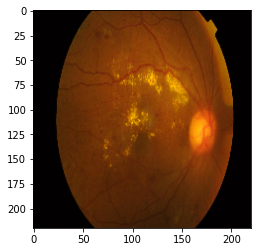

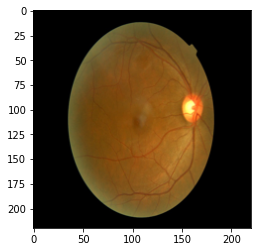

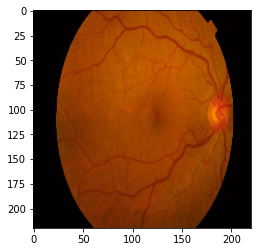

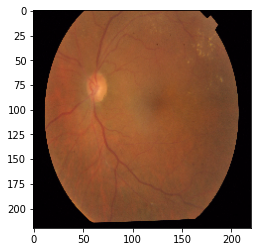

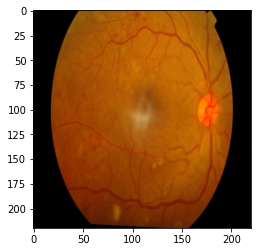

In [57]:
from google.colab.patches import cv2_imshow
import random

x,y = train_generator.next()
for i in range(5):
  image = x[random.randint(0, len(x)-1)]
  plt.imshow(image)
  plt.show()

In [58]:
from keras.layers import Dense, Dropout, Flatten, Add, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D
from keras.layers. normalization import BatchNormalization

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/content/drive/MyDrive/Program/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)

    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [59]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 109, 109, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 109, 109, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 109, 109, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [60]:
#####################
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

87 9


In [61]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['acc'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


87/87 [==============================] - 548s 6s/step - loss: 0.9866 - acc: 0.6494 - val_loss: 1.6921 - val_acc: 0.7222


In [62]:
from keras.callbacks import ModelCheckpoint
filename = 'xception_none1'
filepath=os.path.join('/content/drive/MyDrive/weights/xception', filename+'.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint]

In [63]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callbacks_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
87/87 [==============================] - 291s 3s/step - loss: 0.5961 - acc: 0.7761 - val_loss: 0.7442 - val_acc: 0.7708

Epoch 00001: val_acc improved from -inf to 0.77083, saving model to /content/drive/MyDrive/weights/xception/xception_none1.hdf5
Epoch 2/15
87/87 [==============================] - 295s 3s/step - loss: 0.5531 - acc: 0.7934 - val_loss: 1.1248 - val_acc: 0.7500

Epoch 00002: val_acc did not improve from 0.77083
Epoch 3/15
87/87 [==============================] - 292s 3s/step - loss: 0.5039 - acc: 0.8068 - val_loss: 0.7945 - val_acc: 0.8090

Epoch 00003: val_acc improved from 0.77083 to 0.80903, saving model to /content/drive/MyDrive/weights/xception/xception_none1.hdf5
Epoch 4/15
87/87 [==============================] - 295s 3s/step - loss: 0.4446 - acc: 0.8274 - val_loss: 0.6769 - val_acc: 0.7778

Epoch 00004: val_acc did not improve from 0.80903
Epoch 5/15
87/87 [==============================] - 296s 3s/step - loss: 0.3853 - acc: 0.8487 - val_loss: 0.8446 

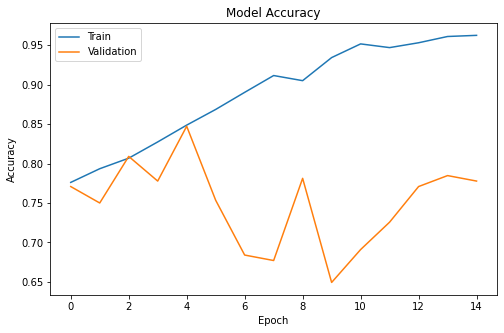

In [64]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['acc'])
plt.plot(history_finetunning['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [65]:
from keras.layers import Dense, Dropout, Flatten, Add, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D
from keras.layers. normalization import BatchNormalization

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/content/drive/MyDrive/Program/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)

    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
model.load_weights(filepath)

In [66]:
#testing part

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory="/content/drive/MyDrive/Dataset/train_images",
                                                x_col="file_name",
                                                y_col="diagnosis",
                                                batch_size=5,
                                                class_mode="categorical",
                                                target_size=(HEIGHT, WIDTH),
                                                shuffle = False)

Found 550 validated image filenames belonging to 5 classes.


In [67]:
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = np.ceil(nb_samples/5))

preds = predict.tolist()
predictions = [i.index(max(i)) for i in preds]

y_actual = list(test['diagnosis'])
y_act = [int(i) for i in y_actual]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [68]:
print(predictions[0:len(predictions):2])
print(y_act[0:len(y_act):2])

[0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 4, 1, 0, 2, 1, 0, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 3, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 4, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 4, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 3, 0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 3, 0, 2, 0, 2, 0, 3, 0, 0, 1, 2, 2, 2, 0, 2, 3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 1, 2, 0, 0]
[0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 3, 0, 0, 1, 0, 0, 4, 0, 0, 4, 2, 3, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,

In [69]:
import sklearn.metrics as skm
y_true = y_act
y_pred = predictions
cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(skm.classification_report(y_true,y_pred))

[[[266  11]
  [  3 270]]

 [[478   8]
  [ 36  28]]

 [[325  86]
  [ 10 129]]

 [[515   3]
  [ 26   6]]

 [[502   6]
  [ 39   3]]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       273
           1       0.78      0.44      0.56        64
           2       0.60      0.93      0.73       139
           3       0.67      0.19      0.29        32
           4       0.33      0.07      0.12        42

    accuracy                           0.79       550
   macro avg       0.67      0.52      0.53       550
weighted avg       0.78      0.79      0.76       550



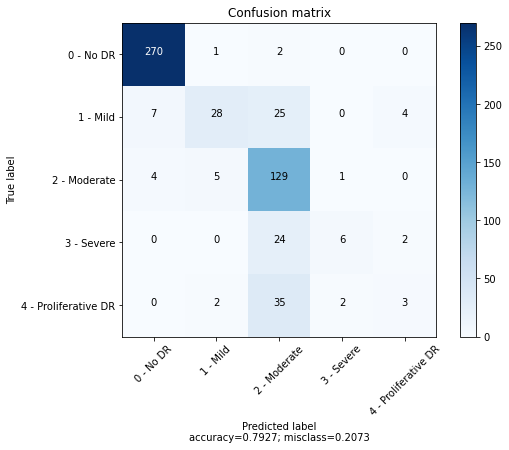





Train Cohen Kappa score: 0.814
Train Accuracy score : 0.793


In [70]:
conf = confusion_matrix(y_pred=predictions, y_true=y_act, labels=[0, 1, 2, 3, 4])

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_confusion_matrix(conf, labels)
print()
print()
print()
print()

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(predictions, y_act, weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(y_act,predictions))

In [71]:
print(y_act,predictions)


[0, 2, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 0, 3, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 4, 0, 2, 1, 3, 2, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 1, 4, 0, 2, 2, 3, 4, 0, 0, 2, 2, 0, 2, 0, 3, 3, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 4, 2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 4, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 4, 3, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 4, 0, 1, 0, 0, 2, 4, 1, 1, 0, 0, 3, 0, 3, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 1, 0, 0, 4, 4, 2, 0, 2, 3, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2, 3, 2, 1, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0, 4, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 2, 4, 0, 0, 0, 0, 2, 4, 2, 1, 1, 4, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 4, 2, 0, 4, 4, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 4, 2, 1, 